# EDA with Lance

In this tutorial we'll go through a quick pre-training data quality check

## Prerequisite

```sh
python -m venv ~/.venv/lance
source ~/.venv/lance/bin/activate
pip install pylance duckdb matplotlib
```

You'll also need AWS credentials configured for data access.
The S3 bucket is public so you just need *any* valid AWS keypair

## Coco Dataset

In this example, we analyze the [Coco dataset](https://cocodataset.org/#home), an object detection dataset.

In [1]:
import lance
import duckdb

In [2]:
coco = lance.dataset("s3://eto-public/datasets/coco/coco.lance")
coco.schema.names

['license',
 'file_name',
 'coco_url',
 'height',
 'width',
 'date_captured',
 'flickr_url',
 'image_id',
 'split',
 'image_uri',
 'annotations',
 'image']

### Understand Label Distributions

In [3]:
coco_names = coco.scanner(columns=["annotations.name", "image_id"])

duckdb.query("""
WITH objects AS (SELECT image_id, UNNEST(annotations.name) AS name FROM coco_names)

SELECT count(image_id) as count
FROM objects
ORDER BY 1 DESC
""").to_df()

,count
0,896782


In [4]:
%%time

coco_names = coco.scanner(columns=["annotations.name", "image_id"])

duckdb.query("""
WITH objects AS (SELECT image_id, UNNEST(annotations.name) AS name FROM coco_names)

SELECT name, count(image_id) as count
FROM objects
GROUP BY 1
ORDER BY 2 DESC
""").to_df()

CPU times: user 783 ms, sys: 135 ms, total: 919 ms
Wall time: 13 s


,name,count
0,person,273469
1,car,45799
2,chair,40282
3,book,25876
4,bottle,25367
...,...,...
75,scissors,1517
76,bear,1365
77,parking meter,1345
78,toaster,234


### Calculate Label Distribution among splits



In [5]:
names_and_split = coco.scanner(columns=["annotations.name", "split"])

class_count_by_split_df = duckdb.query("""
WITH objects AS (SELECT UNNEST(annotations.name) AS name, split FROM names_and_split)

SELECT name, split, count(1) as count
FROM objects
GROUP BY 1, 2 
ORDER BY 1, 2
""").to_df()

class_count_by_split_df 

,name,split,count
0,airplane,train,5135
1,airplane,val,143
2,apple,train,5851
3,apple,val,239
4,backpack,train,8720
...,...,...,...
155,vase,val,277
156,wine glass,train,7913
157,wine glass,val,343
158,zebra,train,5303


## Evaluatings skewness of the dataset, between the split

[Entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory)) and [Skewness](https://en.wikipedia.org/wiki/Skewness) are two statistical methods to indicate how imbalance a dataset is. `DuckDB` supports these statistic functions, making dataset balance check quite easy.

In [6]:
category_and_split = coco.scanner(columns=["annotations.category_id", "split"])

duckdb.query("""
WITH 
  class_and_split AS (
    SELECT UNNEST(annotations.category_id) AS class, split 
    FROM category_and_split
  ),
  label_dist AS (
    SELECT split, class, count(1) as cnt
    FROM class_and_split
    GROUP BY 1, 2
  )
  
SELECT split, entropy(cnt), skewness(cnt) 
FROM label_dist 
GROUP BY 1
""").to_df()

,split,entropy(cnt),skewness(cnt)
0,train,6.321928,8.205029
1,val,6.053056,8.101302


The result shows that while `train` and `val` datasets are highly imbalanced, they do share the similar distribution among labels. A picture is worth a thousand words. Let's render the distribution.

<AxesSubplot: xlabel='name'>

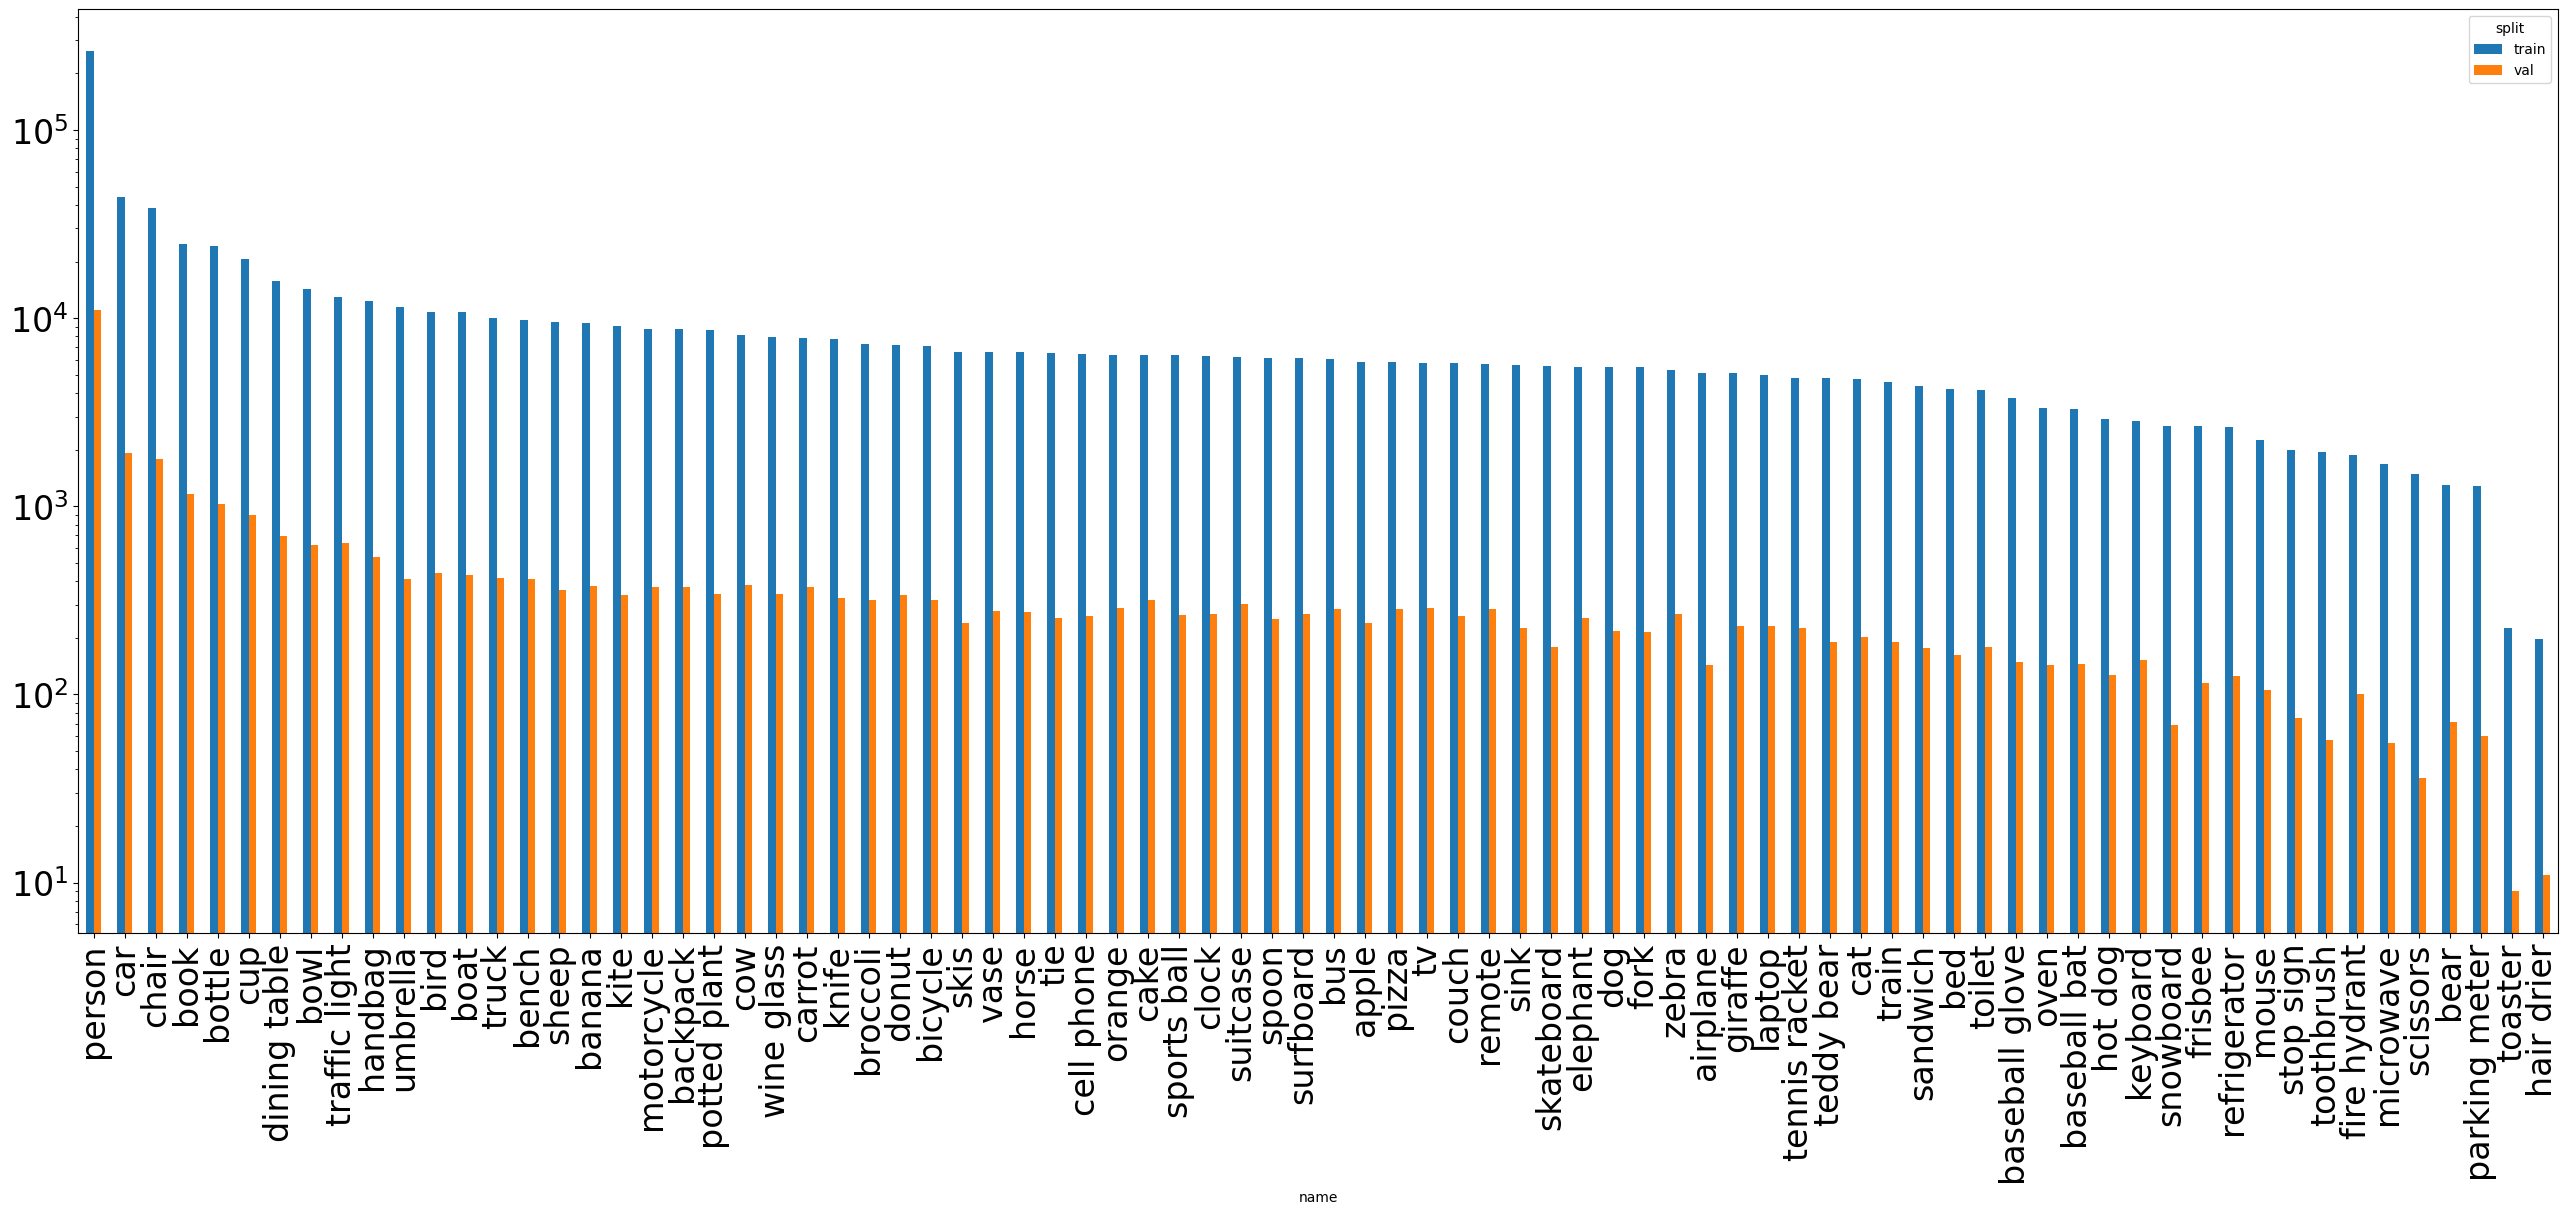

In [7]:
df = (class_count_by_split_df
      .pivot(values='count', index='name', columns='split')
      .sort_values(by='train', ascending=False))
df.plot.bar(figsize=(32, 12), 
            fontsize=24, 
            logy=True)